In [41]:
import sys
from pathlib import Path
project_root = Path('./').resolve().parent
sys.path.append(str(project_root))

In [42]:
from utils.utils import load_yaml_config, concordance_index
from models.ensembles import Ensembles
import numpy as np
from matminer.featurizers.composition import ElementProperty
import pandas as pd

In [43]:
path_config = Path('./').resolve().parent / 'configs' / 'ensembles.yaml'
config = load_yaml_config(path_config)

In [44]:
config['data']['root_dir']=Path('./').resolve().parent / config['data']['root_dir']

In [5]:
config['features']['checkpoint_path']=Path('./').resolve().parent / config['features']['checkpoint_path']

In [6]:
model = Ensembles(**config)
model.prep_data()

RandomForestRegressor(random_state=11)


/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/io/cif.py:1324: UserWarning: Issues encountered while parsing CIF: 16 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/io/cif.py:1324: UserWarning: Issues encountered while parsing CIF: 4 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/io/cif.py:1324: UserWarning: Issues encountered while parsing CIF: 8 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/io/cif.py:1

** Features are being calculated **


/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/libpyg.so, 0x0006): Library not loaded: /Library/Frameworks/Python.framework/Versions/3.11/Python
  Referenced from: <CA14ED34-FA3D-31FE-B4AD-2B2A8446B324> /opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/libpyg.so
  Reason: tried: '/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file), '/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file)
  import torch_geometric.typing
/opt/miniconda3/envs/kpoints/lib/python3.11/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/opt/miniconda3/envs/kpoint

test_ratio 1.0, train_ratio 0.0
calibration False, cal_ratio 0.0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train_ind, test_ind = train_test_split(model.data.index.values, 
                                               test_size=0.2, 
                                               random_state=42)
cal_ind, test_ind = train_test_split(test_ind, 
                                               test_size=0.5, 
                                               random_state=42)
ytrain = np.array(model.data.iloc[train_ind][1].values,dtype='float')
ytest = np.array(model.data.iloc[test_ind][1].values,dtype='float')
ycal = np.array(model.data.iloc[cal_ind][1].values,dtype='float')
Xtrain = model.features[train_ind,:]
Xtest = model.features[test_ind,:]
Xcal = model.features[cal_ind,:]

In [9]:
# model1 = RandomForestQuantileRegressor(q=[0.05,0.5,0.95])

In [10]:
# model1.fit(Xtrain,ytrain)

In [11]:
# import pickle

# import pickle

# with open("/Users/elena.patyukova/Documents/github/clean-kpoints/goldilocks_kpoints/trained_models/RF/QRF85.pkl", "wb") as f:
#     pickle.dump(model1, f)

In [85]:
from sklearn_quantile import RandomForestQuantileRegressor
import pickle

with open("../trained_models/RF/QRF90.pkl", "rb") as f:
    model1 = pickle.load(f)

In [86]:
predictions = model1.predict(Xtest)
cal_predictions = model1.predict(Xcal)

In [87]:
test_y_lower = predictions[0]
test_y_med = predictions[1]
test_y_upper = predictions[2]
cal_y_lower = cal_predictions[0]
cal_y_med = cal_predictions[1]
cal_y_upper = cal_predictions[2]

In [88]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import spearmanr, kendalltau

mse = mean_squared_error(ytest, y_med)
mae = mean_absolute_error(ytest, y_med)
mape = mean_absolute_percentage_error(ytest, y_med)
r2 = r2_score(ytest, y_med)
spearman_corr, _ = spearmanr(ytest, y_med)
kendall_corr, _ = kendalltau(ytest, y_med)
    # c_index = concordance_index(y_test, y_pred[strategy])
print(f'STRATEGY: cqr')
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')
print(f'Test set spearman_corr: {spearman_corr}')
print(f'Test set kendall_corr: {kendall_corr}')

STRATEGY: cqr
Test set MAE: 0.06468098446220209
Test set MAPE: 0.18085659601124549
Test set MSE: 0.009952306790651158
Test set R2 score: 0.690745251357639
Test set spearman_corr: 0.8597459952835392
Test set kendall_corr: 0.6787849276253121


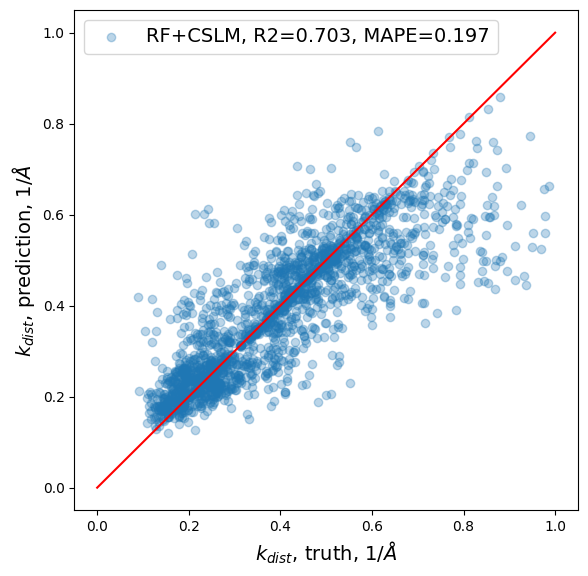

In [89]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6.5,6.5))
plt.scatter(ytest, y_med,alpha=0.3, label='RF+CSLM, R2=0.703, MAPE=0.197')
plt.plot([0,1],[0,1], color='red')
plt.xlabel('$k_{dist}$, truth, $1/\AA$',fontsize=14)
plt.ylabel('$k_{dist}$, prediction, $1/\AA$',fontsize=14)
plt.legend(fontsize=14)
plt.savefig('../figures/RF_CSLM.png', dpi=600)
plt.show()

In [90]:
def conf_score(ytest, y_lower, y_upper):
    a=np.array(y_lower-ytest).reshape(-1, 1)
    b=np.array(ytest-y_upper).reshape(-1,1)
    return np.max(np.concatenate([a,b],axis=1),axis=1)

def conf_intervals(ytest, test_y_lower, test_y_upper, ycal, cal_y_lower, cal_y_upper, alpha=0.1):
    scores=conf_score(ycal, cal_y_lower, cal_y_upper)
    sorted_scores=np.sort(scores)
    conformal_correction=sorted_scores[int(len(ytest)*((1-alpha)*(1+1/len(ytest))))]
    y_lower=test_y_lower-conformal_correction*np.ones(len(ytest))
    y_upper=test_y_upper-conformal_correction*np.ones(len(ytest))
    return y_lower,y_upper

def regression_coverage_score(ytest, y_upper_k,y_lower_k):
    covered=0
    for i in range(len(ytest)):
        if((ytest[i]<y_upper_k[i]) and (ytest[i]>y_lower_k[i])):
            covered+=1
    return covered/len(ytest)

In [94]:
y_lower,y_upper=conf_intervals(ytest, test_y_lower, test_y_upper, ycal, cal_y_lower, cal_y_upper, alpha=0.2)

In [95]:
print(f'Coverage score : {regression_coverage_score(ytest, y_upper, y_lower)}')
print(f'Mean interval length : {np.mean(np.abs(y_lower-y_upper))}')

Coverage score : 0.8260654112983151
Mean interval length : 0.23815358694867997


In [96]:
cov_score=regression_coverage_score(ytest, y_upper, y_lower)
mean_width=np.mean(np.abs(y_lower-y_upper))

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.offsetbox import AnnotationBbox, TextArea
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import randint, uniform
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
import warnings

random_state = 42

In [98]:
random_state = 18
rng = np.random.default_rng(random_state)
round_to = 3
perc_obs_plot = 0.05
num_plots = rng.choice(
    len(ytest), int(perc_obs_plot*len(ytest)), replace=False
    )

In [99]:
def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound

In [75]:
def plot_prediction_intervals(
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots_idx,
    round_to=3
):
    """
    Plot of the prediction intervals for each different conformal method.
    """

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_ - lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_ + error
    warning2 = y_test_sorted_ < y_pred_sorted_ - error
    warnings = warning1 + warning2

    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=np.abs(error[~warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        alpha=0.8,
        label="Inside prediction interval"
    )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr=np.abs(error[warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0, color="midnightblue",
        alpha=0.8,
        label="Outside prediction interval"
    )

    # Labels
    axs.set_xlabel("$k_{dist}$, truth, $1/\\AA$", fontsize=14)
    axs.set_ylabel("$k_{dist}$, prediction, $1/\\AA$", fontsize=14)

    # Make axis tick labels larger
    axs.tick_params(axis='both', labelsize=14)

    # Annotation box in upper-left corner
    ab = AnnotationBbox(
        TextArea(
            f"Coverage: {np.round(coverage, round_to)}\n"
            f"Interval width: {np.round(width, round_to)}",
            textprops=dict(size=14)
        ),
        xy=(0.02, 0.98),          # upper-left corner in axes coordinates
        xycoords="axes fraction",
        box_alignment=(0, 1),
        frameon=True
    )
    axs.add_artist(ab)

    # Identity line
    lims = [
        np.min([axs.get_xlim(), axs.get_ylim()]),
        np.max([axs.get_xlim(), axs.get_ylim()])
    ]
    axs.plot(lims, lims, alpha=0.75, color="red", label="x=y")
    axs.set_xlim(lims)
    axs.set_ylim(lims)

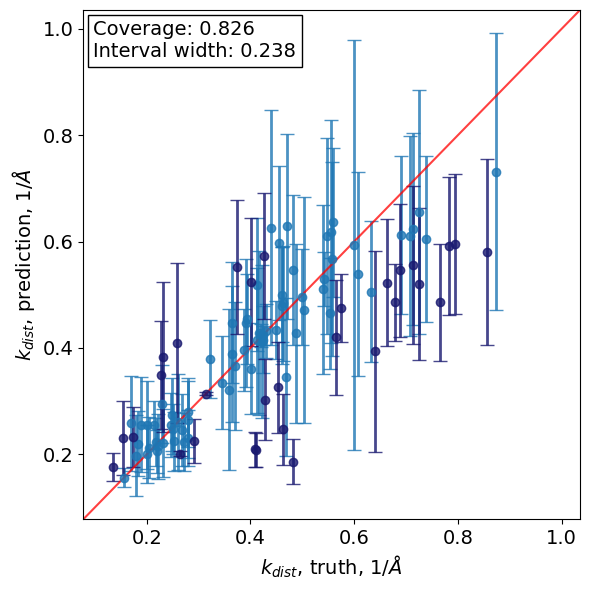

In [100]:
from matplotlib.offsetbox import AnnotationBbox, TextArea
perc_obs_plot = 0.05
num_plots = rng.choice(
    len(ytest), int(perc_obs_plot*len(ytest)), replace=False
    )

fig, ax = plt.subplots(figsize=(6, 6))

plot_prediction_intervals(
    ax,
    ytest,
    test_y_med,
    y_lower,
    y_upper,
    cov_score,
    mean_width,
    num_plots
)

# ax.legend()
plt.tight_layout()
plt.savefig('../figures/RF_CQR_80.png', dpi=600)
plt.show()

In [ ]:
# from sklearn.linear_model import QuantileRegressor

# # quantile < 0.5 penalizes underestimation more
# q = 0.  # You can tune this
# model = QuantileRegressor(quantile=q, alpha=0, fit_intercept=True)
# X_dummy = np.ones((len(y_train), 1)) # dummy feature, constant model
# model.fit(X_dummy, y_train)
# ypred=model.predict(X_dummy)

# c_opt = ypred[0]
# c_opt

In [ ]:
# CQR90: c_opt=0.158, CQR80: c_opt=0.184, CQR70: c_opt=0.205

In [77]:
c_opt=0.205

In [78]:
dummy_errors=c_opt-ytest

In [79]:
errors=y_lower-ytest
errors_pos=errors*np.array([errors>0],dtype='int').ravel()
errors_pos=[x for x in errors_pos if x != 0]

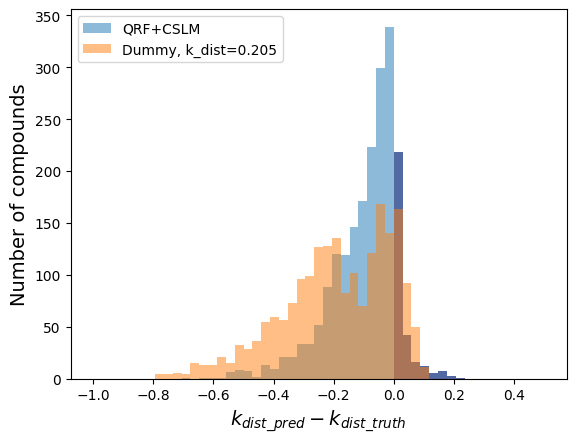

In [80]:
plt.hist(errors, bins=51, range=(-1,0.5), alpha=0.5,label='QRF+CSLM')
plt.hist(errors_pos, bins=51, range=(-1,0.5), alpha=0.5,color='midnightblue')
plt.hist(dummy_errors, bins=51, range=(-1,0.5), alpha=0.5, label=f'Dummy, k_dist={np.round(c_opt,3)}')
plt.xlabel('$k_{dist\_pred}-k_{dist\_truth}$', fontsize=14)
plt.ylabel('Number of compounds',fontsize=14)
plt.legend()
plt.savefig('../figures/RF+baseline_CQR70.png', dpi=600)
plt.show()

In [81]:
np.mean(np.abs(errors)),np.mean(np.abs(dummy_errors))

(np.float64(0.10444594818235892), np.float64(0.20036854728322065))

In [82]:
np.sum([errors>0]), np.sum([errors>0])/len(errors), np.sum([dummy_errors>0]), np.sum([dummy_errors>0])/len(dummy_errors)

(np.int64(304),
 np.float64(0.1506442021803766),
 np.int64(316),
 np.float64(0.1565906838453915))

In [83]:
1-np.sum([errors>0])/len(errors), 1-np.sum([dummy_errors>0])/len(dummy_errors)

(np.float64(0.8493557978196233), np.float64(0.8434093161546086))

# Esimation of wall time gain

In [91]:
dummy_times=[]
lower_times=[]
true_times=[]
predicted_times=[]
ypred_corr=[]
for i in range(len(testset)):
    ind=testset.iloc[i]['source_db_id']
    dx=da.loc[da['Source ID']==ind]
    true_k_dist=testset.iloc[i]['k_dist']
    true_time=dx.loc[dx['k_dist']==testset.iloc[i]['k_dist']]['wall_time_s'].values[0]
    true_times.append(true_time)
    try:
        predicted_k_dist=testset.iloc[i]['ypred']
        ind_pred=np.searchsorted(np.array(predicted_k_dist*np.ones(len(dx))-dx['k_dist']),0)
        ypred_corr.append(dx.iloc[ind_pred]['k_dist'])
        predicted_time=dx.iloc[ind_pred]['wall_time_s']
    except:
        predicted_time=np.nan
        ypred_corr.append(np.nan)
    predicted_times.append(predicted_time)
    try:
        lower_k_dist=testset.iloc[i]['ylower']
        ind_lower=np.searchsorted(np.array(lower_k_dist*np.ones(len(dx))-dx['k_dist']),0)
        lower_time=dx.iloc[ind_lower]['wall_time_s']
    except:
        lower_time=np.nan
    lower_times.append(lower_time)
    try:
        dummy_k_dist=testset.iloc[i]['ydummy']
        ind_dummy=np.searchsorted(np.array(dummy_k_dist*np.ones(len(dx))-dx['k_dist']),0)
        dummy_time=dx.iloc[ind_dummy]['wall_time_s']
    except:
        dummy_time=np.nan
    dummy_times.append(dummy_time)

In [92]:
testset['ypred_corr']=ypred_corr
testset['true_times']=true_times
testset['predicted_times']=predicted_times
testset['lower_times']=lower_times
testset['dummy_times']=dummy_times

/var/folders/v7/cqz0y8fn2sjc927rqlt460_m0000gp/T/ipykernel_22498/4074071194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testset['ypred_corr']=ypred_corr
/var/folders/v7/cqz0y8fn2sjc927rqlt460_m0000gp/T/ipykernel_22498/4074071194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testset['true_times']=true_times
/var/folders/v7/cqz0y8fn2sjc927rqlt460_m0000gp/T/ipykernel_22498/4074071194.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [93]:
testset1=testset.loc[~testset['ypred_corr'].isna()]

In [94]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import spearmanr, kendalltau

mse = mean_squared_error(testset['ytest'], testset['ypred'])
mae = mean_absolute_error(testset['ytest'], testset['ypred'])
mape = mean_absolute_percentage_error(testset['ytest'], testset['ypred'])
r2 = r2_score(testset['ytest'], testset['ypred'])
spearman_corr, _ = spearmanr(testset['ytest'], testset['ypred'])
kendall_corr, _ = kendalltau(testset['ytest'], testset['ypred'])
    # c_index = concordance_index(y_test, y_pred[strategy])
print(f'STRATEGY: cqr')
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')
print(f'Test set spearman_corr: {spearman_corr}')
print(f'Test set kendall_corr: {kendall_corr}')

STRATEGY: cqr
Test set MAE: 0.06398983923764567
Test set MAPE: 0.17687615808285098
Test set MSE: 0.00986684835405773
Test set R2 score: 0.6764903036514403
Test set spearman_corr: 0.8554559247033494
Test set kendall_corr: 0.6779342211125541


In [95]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import spearmanr, kendalltau

mse = mean_squared_error(testset1['ytest'], testset1['ypred_corr'])
mae = mean_absolute_error(testset1['ytest'], testset1['ypred_corr'])
mape = mean_absolute_percentage_error(testset1['ytest'], testset1['ypred_corr'])
r2 = r2_score(testset1['ytest'], testset1['ypred_corr'])
spearman_corr, _ = spearmanr(testset1['ytest'], testset1['ypred_corr'])
kendall_corr, _ = kendalltau(testset1['ytest'], testset1['ypred_corr'])
    # c_index = concordance_index(y_test, y_pred[strategy])
print(f'STRATEGY: cqr')
print(f'Test set MAE: {mae}')
print(f'Test set MAPE: {mape}')
print(f'Test set MSE: {mse}')
print(f'Test set R2 score: {r2}')
print(f'Test set spearman_corr: {spearman_corr}')
print(f'Test set kendall_corr: {kendall_corr}')

STRATEGY: cqr
Test set MAE: 0.0745776220511229
Test set MAPE: 0.17786116281343306
Test set MSE: 0.014347029990978996
Test set R2 score: 0.5389577368011753
Test set spearman_corr: 0.8445355371055618
Test set kendall_corr: 0.6609728289309326


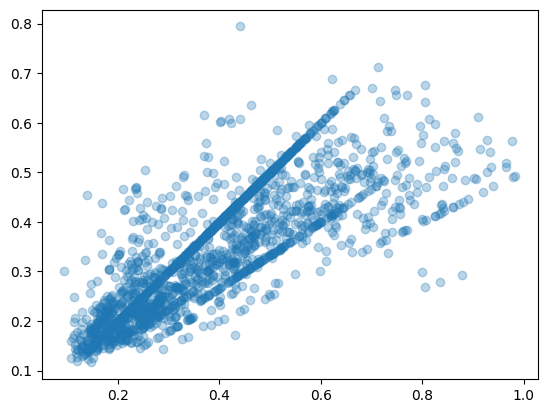

In [96]:
import matplotlib.pyplot as plt
plt.scatter(testset1['ytest'], testset1['ypred_corr'],alpha=0.3)
plt.show()

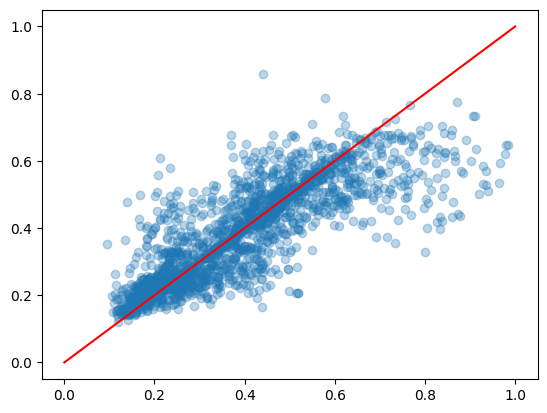

In [97]:
import matplotlib.pyplot as plt
plt.scatter(testset['ytest'], testset['ypred'],alpha=0.3)
plt.plot([0,1],[0,1], color='red')
plt.show()

In [98]:
dy=testset.loc[~testset['lower_times'].isna()]
dyy=dy.loc[~dy['dummy_times'].isna()]

In [99]:
len(dyy),len(dy)

(928, 1773)

In [100]:
def wasted_time(true_val,pred_val):
    times=[]
    for i in range(len(true_val)):
        x=pred_val[i]-true_val[i]
        if(x>=0):
            times.append(x)
        else:
            times.append(pred_val[i])
    return times

In [101]:
cost_dummy=wasted_time(dyy['true_times'].values,dyy['dummy_times'].values)
cost_lower=wasted_time(dyy['true_times'].values,dyy['lower_times'].values)
cost_pred=wasted_time(dyy['true_times'].values,dyy['predicted_times'].values)

In [103]:
np.mean(cost_dummy),np.mean(cost_lower)

(np.float64(240.02558189655176), np.float64(222.97009698275863))

In [104]:
(240-223)/240

0.07083333333333333

In [74]:
318-277, (318-277)/318

(41, 0.1289308176100629)

In [76]:
np.mean(dyy['true_times'])

np.float64(352.96364341085274)

In [42]:
# alpha =0.9 np.mean(cost_dummy),np.mean(cost_lower)
# (np.float64(496.88961305925034), np.float64(387.6366747279323))

(np.float64(496.88961305925034), np.float64(387.6366747279323))

In [75]:
496-387, (496-387)/496

(109, 0.21975806451612903)

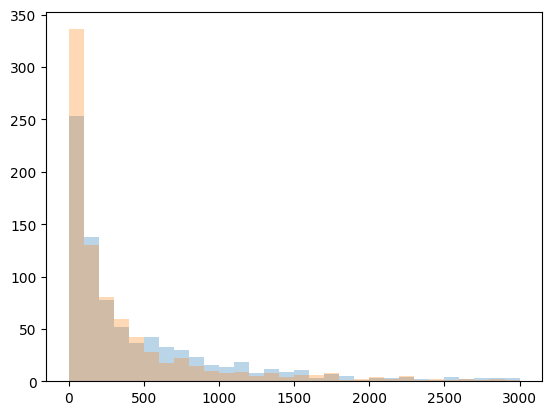

In [43]:
# plt.hist(cost_pred, bins=50, alpha=0.3, range=(0,3000))
plt.hist(cost_dummy, bins=30, alpha=0.3, range=(0,3000))
plt.hist(cost_lower, bins=30, alpha=0.3, range=(0,3000))
plt.show()

In [75]:
def compute_kmesh_from_kdist(kdist, structure):
    """
    Compute the maximum distance between k-points (kdist) from a given mesh and reciprocal cell.
 
    Input:
    kpointsmesh: List[int] of number of k-points along each reciprocal lattice vector
    structure: pymatgen structure
    Output:
    estimated maximum k-point spacing (in Å⁻¹): float
    """
    recip_lattice = structure.lattice.reciprocal_lattice
    g1, g2, g3 = recip_lattice.matrix
    norms = np.linalg.norm([g1, g2, g3], axis=1)  
    kmesh = []
   
    for bn in norms:
        kmesh.append(np.ceil(bn/kdist))
        
    return kmesh

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [65]:
y_lower

array([0.18190598, 0.19889198, 0.14432248, ..., 0.11472618, 0.19248044,
       0.13778895], shape=(2018,))

In [64]:
dff=df[['source_db_id','Formula','structure','ultra k-mesh','k_dist']]

In [65]:
dff.to_pickle('/Users/elena.patyukova/Documents/github/clean-kpoints/goldilocks_kpoints/data/cgcnn_junwen_oct_6_kdist/junwen_6_oct_no_structural_duplicates_kdist_with_supercell_simplified.pkl')


In [63]:
df

,File,source_db_id,Formula,MC3D mesh,medium k-mesh,well k-mesh,ultra k-mesh,medium_k_number,well_k_number,ultra_k_number,medium_k_distance,well_k_distance,ultra_k_distance,structure,density,k_dist
0,./S1320563/S1320563_v4.csv,S1320563,La1 Ag1 As2,"[11, 11, 4]","[7, 7, 3]",NaN,"[13, 13, 5]",20.0,NaN,84.0,0.254,NaN,0.127,"[[2.05806546 0. 2.49124624] La, [-1.26...",7.204742,0.117421
1,./22395/22395_v4.csv,22395,Na1 O3 Cl1,"[7, 7, 7]",NaN,NaN,"(2, 2, 2)",NaN,NaN,4.0,NaN,NaN,0.935,"[[2.90625486 6.26407245 3.80938032] Na, [6.264...",2.334300,0.467803
2,./S1825691/S1825691_v4.csv,S1825691,Ba1 S1 O4,"[8, 6, 5]","(2, 2, 1)",NaN,"(2, 2, 2)",4.0,NaN,8.0,0.863,NaN,0.698,"[[1.38932642 4.31802203 6.16723031] Ba, [4.171...",4.259571,0.564681
3,./S1936300/S1936300_v4.csv,S1936300,Cs2 Na1 Gd1 Br6,"[7, 7, 7]",NaN,NaN,"[5, 5, 5]",NaN,NaN,19.0,NaN,NaN,0.235,"[[ 7.07672867 5.00400283 12.25725361] Cs, [2....",3.983115,0.188345
4,./191281/191281_v4.csv,191281,K2 Fe1 P2 O7,"[6, 6, 8]",NaN,NaN,"(2, 2, 2)",NaN,NaN,6.0,NaN,NaN,0.767,"[[6.82244963 2.7269983 2.87656046] K, [2.7269...",2.704449,0.557293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20173,./7229267/7229267_v4.csv,7229267,Ba1 Cd1 Se2 O6,"[3, 8, 6]","(1, 2, 2)",NaN,"(1, 3, 2)",4.0,NaN,4.0,0.861,NaN,0.566,"[[4.73363158 4.15853608 2.756024 ] Ba, [3.668...",4.924206,0.430891
20174,./S1720146/S1720146_v4.csv,S1720146,Na1 O4 Cl1,"[9, 9, 6]",NaN,"(2, 2, 2)","(3, 3, 2)",NaN,8.0,10.0,NaN,0.866,0.642,"[[3.41328372 1.63937183 1.81195525] Na, [1.943...",2.337415,0.433453
20175,./S1021849/S1021849_v4.csv,S1021849,Na1 Pr1 Ti1 O4,"[12, 12, 4]","(3, 3, 1)","(4, 4, 1)","(4, 4, 2)",3.0,6.0,12.0,0.835,0.556,0.480,"[[1.88092397 0. 7.63117345] Na, [-1.15...",4.945255,0.417560
20176,./S527544/S527544_v4.csv,S527544,K1 P1,"[7, 7, 4]","(2, 2, 2)","(3, 2, 2)","(3, 3, 2)",8.0,8.0,8.0,0.549,0.515,0.474,"[[ 2.42239812 5.84593663 10.47764415] K, [5.4...",2.020840,0.343629


In [62]:
df=pd.read_pickle('/Users/elena.patyukova/Documents/github/clean-kpoints/goldilocks_kpoints/data/cgcnn_junwen_oct_6_kdist/junwen_6_oct_no_structural_duplicates_kdist_with_supercell.pkl')

In [10]:
da=pd.read_pickle('/Users/elena.patyukova/Documents/github/clean-kpoints/goldilocks_kpoints/data/cgcnn_junwen_oct_6_kdist/wall_times.pkl')

In [19]:
df.loc[df['source_db_id']=='S1320563']

,File,source_db_id,Formula,MC3D mesh,medium k-mesh,well k-mesh,ultra k-mesh,medium_k_number,well_k_number,ultra_k_number,medium_k_distance,well_k_distance,ultra_k_distance,structure,density,k_dist
0,./S1320563/S1320563_v4.csv,S1320563,La1 Ag1 As2,"[11, 11, 4]","[7, 7, 3]",NaN,"[13, 13, 5]",20.0,NaN,84.0,0.254,NaN,0.127,"[[2.05806546 0. 2.49124624] La, [-1.26...",7.204742,0.117421


In [17]:
da.loc[da['Source ID']=='S1320563']

,Formula,Source ID,Goldilocks_kpoints,wall_time,wall_time_s,structure,k_dist
0,La1 Ag1 As2,S1320563,"2, 2, 1",20.70s,20.70,"[[2.05806546 0. 2.49124624] La, [-1.26...",0.763239
1,La1 Ag1 As2,S1320563,"3, 3, 1",17.28s,17.28,"[[2.05806546 0. 2.49124624] La, [-1.26...",0.582273
2,La1 Ag1 As2,S1320563,"3, 3, 2",17.70s,17.70,"[[2.05806546 0. 2.49124624] La, [-1.26...",0.508826
3,La1 Ag1 As2,S1320563,"4, 4, 2",27.03s,27.03,"[[2.05806546 0. 2.49124624] La, [-1.26...",0.381620
4,La1 Ag1 As2,S1320563,"5, 5, 2",30.00s,30.00,"[[2.05806546 0. 2.49124624] La, [-1.26...",0.305296
5,La1 Ag1 As2,S1320563,"6, 6, 2",46.72s,46.72,"[[2.05806546 0. 2.49124624] La, [-1.26...",0.291136
6,La1 Ag1 As2,S1320563,"6, 6, 3",46.68s,46.68,"[[2.05806546 0. 2.49124624] La, [-1.26...",0.254413
7,La1 Ag1 As2,S1320563,"7, 7, 3",41.98s,41.98,"[[2.05806546 0. 2.49124624] La, [-1.26...",0.218068
8,La1 Ag1 As2,S1320563,"8, 8, 3",56.90s,56.90,"[[2.05806546 0. 2.49124624] La, [-1.26...",0.194091
9,La1 Ag1 As2,S1320563,"9, 9, 4",1m14.92s,74.92,"[[2.05806546 0. 2.49124624] La, [-1.26...",0.169609


In [109]:
testset

,File,source_db_id,Formula,MC3D mesh,medium k-mesh,well k-mesh,ultra k-mesh,medium_k_number,well_k_number,ultra_k_number,...,k_dist,ytest,ypred,ylower,ydummy,ypred_corr,true_times,predicted_times,lower_times,dummy_times
5674,./S1110308/S1110308_v4.csv,S1110308,Ba6 Tb1 In1 B6 O18,"[6, 6, 6]",NaN,NaN,"(2, 2, 2)",NaN,NaN,8.0,...,0.431124,0.431124,0.215276,0.216330,0.205437,0.172450,65.93,2310.46,1445.17,2310.46
19572,./S1714980/S1714980_v4.csv,S1714980,Rb2 Na1 Gd1 Cl6,"[4, 4, 4]",NaN,NaN,"(3, 3, 3)",NaN,NaN,6.0,...,0.192917,0.192917,0.291310,0.203775,0.205437,0.289375,517.98,55.15,517.98,517.98
17351,./S1910560/S1910560_v4.csv,S1910560,Sc1 Cu1 Sn1,"[11, 11, 7]","[5, 5, 3]",NaN,"[7, 7, 4]",10.0,NaN,24.0,...,0.234529,0.234529,0.231026,0.173007,0.205437,0.227996,39.58,50.81,89.95,51.31
6982,./S1414876/S1414876_v4.csv,S1414876,Ti2 P2 H4 O11,"[9, 5, 5]","(2, 1, 2)","(2, 2, 2)","(3, 2, 2)",4.0,8.0,8.0,...,0.402983,0.402983,0.649122,0.465070,0.205437,0.604475,102.03,108.83,102.03,NaN
8509,./S1010593/S1010593_v4.csv,S1010593,Na2 Cd1 Sn1,"[10, 10, 5]",NaN,"(9, 9, 4)","(10, 10, 5)",NaN,36.0,42.0,...,0.143233,0.143233,0.176731,0.157704,0.205437,0.159148,61.87,43.63,61.87,26.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,./S1700301/S1700301_v4.csv,S1700301,Ba3 Cd1 Si2 O8,"[9, 9, 6]",NaN,NaN,"(3, 3, 2)",NaN,NaN,6.0,...,0.421314,0.421314,0.414495,0.383451,0.205437,0.312583,39.13,51.13,51.13,NaN
6012,./S1250264/S1250264_v4.csv,S1250264,La1 P2,"[6, 6, 7]",NaN,NaN,"[4, 4, 4]",NaN,NaN,36.0,...,0.249201,0.249201,0.325429,0.244496,0.205437,0.277790,380.31,316.22,731.97,723.57
6941,./S550532/S550532_v4.csv,S550532,Bi1 Te1 I1,"[11, 11, 6]","[4, 4, 3]","[6, 6, 3]","[7, 7, 4]",9.0,17.0,28.0,...,0.234587,0.234587,0.231537,0.156826,0.205437,0.211577,7.82,8.53,14.75,9.35
6805,./S1710260/S1710260_v4.csv,S1710260,Al3 Te3 I1,"[4, 11, 2]","(2, 5, 1)",NaN,"(2, 6, 1)",6.0,NaN,8.0,...,0.290951,0.290951,0.308728,0.218865,0.205437,0.303085,61.63,51.21,122.78,137.38
